In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from copy import copy
warnings.simplefilter("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False 

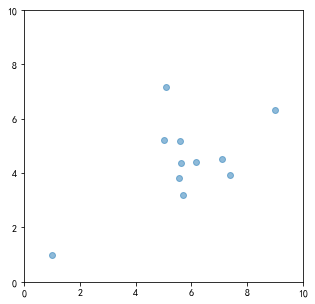

In [2]:
np.random.seed(4028239)
x = np.random.randn(10, 2) * 1.5 + 5
x_out = np.array([[1, 1]])
x = np.concatenate([x, x_out])

idx = np.arange(len(x)).reshape(-1, 1)
x = np.concatenate([idx, x], axis=1)

plt.figure(figsize=(5, 5))
plt.scatter(x[:,1], x[:,2], cmap='Set1', alpha=0.5)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [3]:
class Node(object):
    def __init__(self, name, samples, dept):
        self.name = name 
        self.samples = samples
        self.dept = dept
        self.child_nodes = list()
        self.parent = None 
        self.split_f = None 
        self.split_x = None
        self.child_left = None
        self.child_right = None
        self.children = list()
        self.leaf = False 
        self.is_leaf()
        self.split()
        # self.show()
        pass
    
    def show(self):
        print(f"=" * 50)
        print(f"self.name = {self.name}")
        print(f"self.samples.shape = {self.samples.shape}")
        print(f"self.dept = {self.dept}")
        print(f"self.leaf = {self.leaf}")
        print(f"self.split_f = {self.split_f}")
        print(f"self.split_x = {self.split_x}")
        print(f"self.child_left.shape = {self.child_left.shape}")
        print(f"self.child_right.shape = {self.child_right.shape}")
        print(f"self.child_nodes = {[i.name for i in self.child_nodes]}")
        print(f"=" * 50)
        pass 
    
    
    def is_leaf(self):
        if len(self.samples)==1:
            self.leaf = True
        pass 
    
    def split(self):
        fes = self.samples.shape[1]
        f = np.random.choice(np.array(list(range(1, fes)))) # 随机一个特征
        x = self.samples[:, f]
        xmin, xmax = x.min(), x.max()
        xh = np.random.uniform(xmin, xmax) # 随机一个阈值（最大值和最小值之间）
        self.split_f = f 
        self.split_x = xh 
        child_left, child_right = list(), list()
        for i, v in enumerate(x):
            if v>=xh:
                child_right.append(self.samples[i])
            else:
                child_left.append(self.samples[i])
        self.child_left = np.array(child_left)
        self.child_right = np.array(child_right) 
        self.children = [self.child_left, self.child_right]
        #print(self.child_left)
        #print(self.child_right)
        pass
    
    pass 



class Tree(object):
    def __init__(self, x):
        self.x = x
        self.root = Node("root", x, 1)
        self.visited = list()
        self.nodes = list()
        self.dft = None 
        # self.generate(self.root)
        self.generate_full()
        self.score_samples()
        # self.show()
        pass
    
    def show(self):
        # self.root.show()
        print(self.dft)
        pass
    
    def generate(self, root):
        if root.leaf is False: # 非叶节点才会继续生长
            sams = root.children
            name = root.name
            dept = root.dept
            for i, sam in enumerate(sams):
                node = Node(name+'-'+str(i), sam, dept+1)
                node.parent = root 
                root.child_nodes.append(node)
        pass 
    
    def generate_full(self):
        # 广度优先生长
        self.generate(self.root) # 先生长出两个子节点
        queue = copy(self.root.child_nodes) # 队列，先进先出，广度优先搜索
        visit = [self.root]
        while len(queue)>0:
            node = queue[0]
            self.nodes.append(node)
            visit.append(node)
            self.generate(node)
            queue.extend(node.child_nodes)
            queue.pop(0)
        self.visited = [i.name for i in visit]
        pass 
    
    def score_samples(self):
        res = [(i.name, i.leaf, i.dept) for i in self.nodes if i.leaf is True]
        dft1 = pd.DataFrame(res, columns=["name", "is_leaf", "dept"])
        dat = [i.samples[0] for i in self.nodes if i.leaf is True]
        dft2 = pd.DataFrame(dat, columns=["id", "x1", "x2"])    
        dft = pd.merge(dft1, dft2, left_index=True, right_index=True)
        dft.sort_values(by="id", inplace=True)
        self.dft = dft.copy()
        pass 
    pass 


class Forest(object):
    def __init__(self, x, nums=10):
        self.trees = list()
        for i in range(nums):
            tree = Tree(x)
            self.trees.append(copy(tree))
        self.abnormal_score()
        pass
    
    def abnormal_score(self):
        dfts = list()
        for i, tree in enumerate(self.trees):
            dft = copy(tree.dft)
            dft = dft.set_index(["id", "x1", "x2"])[["dept"]]
            dft.rename(columns={"dept":"dept-"+str(i)})
            dfts.append(dft)
        dfts = pd.concat(dfts, axis=1)

        cs = np.mean(dfts.max(axis=0))  # 每棵树的平均深度
        hs = dfts.mean(axis=1) # 每个样本的平均高度
        ss = np.power(2, -(hs/cs)) # 每个样本点的异常得分值
        """
        如果异常得分接近 1，那么一定是异常点；
        如果异常得分远小于 0.5，那么一定不是异常点；
        如果异常得分所有点的得分都在 0.5 左右，那么样本中很可能不存在异常点。
        """
        
        self.abnormal_dft = ss.copy()
    pass 

forest = Forest(x, nums=10)
forest.abnormal_dft

id    x1        x2      
0.0   5.679184  3.175162    0.584389
1.0   5.569046  3.808617    0.549999
2.0   5.586509  5.176433    0.549999
3.0   5.023709  5.218660    0.579347
4.0   5.632706  4.382866    0.513167
5.0   6.176925  4.408230    0.545254
6.0   7.107798  4.530831    0.584389
7.0   7.376018  3.923215    0.604997
8.0   8.994606  6.334403    0.713260
9.0   5.076190  7.164733    0.683020
10.0  1.000000  1.000000    0.798298
dtype: float64

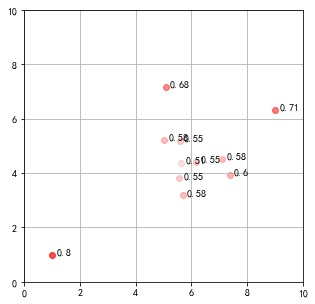

In [4]:
res = pd.DataFrame(forest.abnormal_dft).reset_index()

plt.figure(figsize=(5, 5))
for i in range(len(res)):
    item = res.iloc[i] 
    idx, x1, x2, prob = item 
    prob = round(prob, 2)
    plt.scatter([x1], [x2], c='red', alpha=min((prob-0.45)*2, 1))
    plt.annotate(prob, xy=(x1, x2), xytext=(x1+0.15, x2))
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid()
plt.show()